# Classification

In [1]:
# Test if GPU is active

import tensorflow as tf


In [2]:
#Display tf version and test if GPU is active

tf.__version__, tf.test.gpu_device_name()

('2.6.0', '/device:GPU:0')

# Loading the Fashion-MNIST as a TFDS

In [3]:
#Load train and test examples as a tf.data.Dataset

import tensorflow_datasets as tfds

In [4]:
train , info = tfds.load("fashion_mnist",split="train",with_info=True,shuffle_files=True)
test = tfds.load("fashion_mnist",split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteEESTF9/fashion_mnist-train.tfrecord


  0%|          | 0/60000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteEESTF9/fashion_mnist-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
# Verify train and test data

train.element_spec, test.element_spec

({'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
  'label': TensorSpec(shape=(), dtype=tf.int64, name=None)},
 {'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None),
  'label': TensorSpec(shape=(), dtype=tf.int64, name=None)})

# Explore the Dataset

In [6]:
#Display info about the dataset

info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    version=3.0.1,
    description='Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.',
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/abs-1708-07747,
      author    = {Han Xiao and
                   Kashif Rasul and
                   Roland Vollgraf},
      title     = {Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning
                   Algorithms},
      journal   = {CoRR},
      volume

In [7]:
# Extract the number of classes and class labels

br = "\n"

num_classes = info.features["label"].num_classes
class_labels = info.features["label"].names
print("number of classes:", num_classes,br)
print("class labels:",class_labels)

number of classes: 10 

class labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


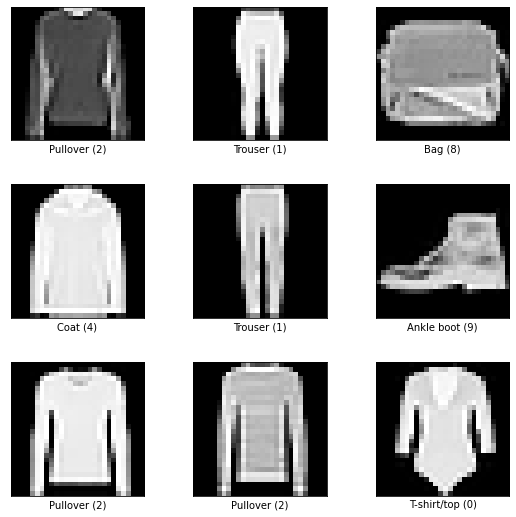

In [8]:
# Viewing some training examples

fig = tfds.show_examples(train,info)

In [9]:
# Custom function that displays samples from the train dataset

import matplotlib.pyplot as plt
import numpy as np


In [10]:
def display_samples(data,num,cmap):
  for example in data.take(num):
    image , label = example["image"], example["label"]
    print("Label:",class_labels[label.numpy()],end= ",")
    print("Index:",label.numpy())
    plt.imshow(image.numpy()[:,:,0].astype(np.float32),cmap=plt.get_cmap(cmap))
    plt.show()

Label: Pullover,Index: 2


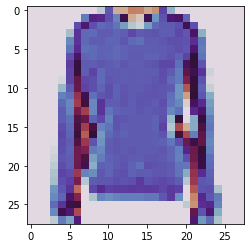

Label: Trouser,Index: 1


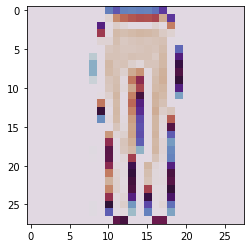

In [11]:
# Invoking the function to display a couple of training images

# Choose colormap by changing "indx"

indx = 5
cmap = ['coolwarm', 'viridis', 'plasma',
        'seismic', 'copper', 'twilight']
samples = 2
display_samples(train, samples, cmap[indx])

In [12]:
# Getting 30 samples from the train set as shown

num = 30

images, labels = [] , []

for example in train.take(num):
  image, label = example["image"] , example["label"]
  images.append(tf.squeeze(image.numpy()))
  labels.append(tf.squeeze(label.numpy()))

In [13]:
# creating a custom function to display a grid of samples

def display_grid(feature, target, n_rows,n_cols,cl):
  plt.figure(figsize=(n_cols*1.5,n_rows*1.5))
  for row in range(n_rows):
    for col in range(n_cols):
      index = n_cols * row + col
      plt.subplot(n_rows, n_cols, index + 1)
      plt.imshow(feature[index],cmap="binary",interpolation="nearest")
      plt.axis("off")
      plt.title(cl[target[index]],fontsize=12)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)

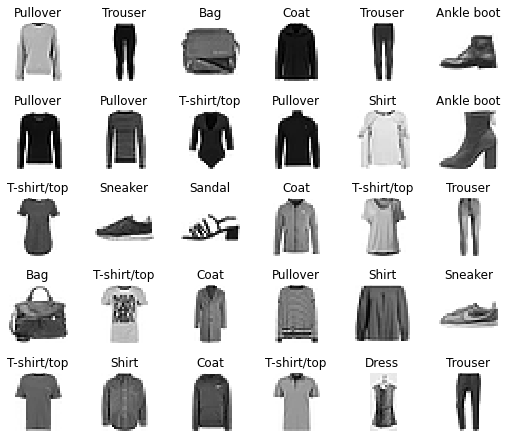

In [14]:
#Invoke the function

rows = 5
cols = 6

display_grid(images,labels,rows,cols,class_labels)

In [15]:
#Displaying metadata with DatasetInfo

print("Number of training examples:",end=" ")
print(info.splits["train"].num_examples)

print("Number of test examples:",end=" ")
print(info.splits["test"].num_examples)

Number of training examples: 60000
Number of test examples: 10000


# Build the input Pipeline

In [16]:
# Build the input pipeline for train and test data

BATCH_SIZE = 128
SHUFFLE_SIZE = 5000


In [17]:
train_f1 = train.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE)
train_f2 = train_f1.map(lambda items: (
    tf.cast(items['image'], tf.float32) / 255., items['label']))
train_fs = train_f2.cache().prefetch(1)

test_f1 = test.batch(BATCH_SIZE)
test_f2 = test_f1.map(lambda items: (
    tf.cast(items['image'], tf.float32) / 255., items['label']))
test_fs = test_f2.cache().prefetch(1)

In [18]:
# Verify train and test tensors

train_fs.element_spec , test_fs.element_spec

((TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)),
 (TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.int64, name=None)))

# Build the Model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [20]:
#clear previous model and genrate a seed

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

In [21]:
model = Sequential([Flatten(input_shape=[28,28,1]),Dense(512,activation="relu"),Dropout(0.4),Dense(10,activation="softmax")])

# Model Summary

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


# Compile the model

In [23]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train the Model

In [24]:
# Train the model with ten epochs


history = model.fit(train_fs,epochs=10,verbose=1,validation_data=test_fs)

Epoch 1/10
469/469 [==============================] - 8s 12ms/step - loss: 0.5514 - accuracy: 0.8051 - val_loss: 0.4408 - val_accuracy: 0.8407
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.4094 - accuracy: 0.8523 - val_loss: 0.3953 - val_accuracy: 0.8617
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3723 - accuracy: 0.8653 - val_loss: 0.3752 - val_accuracy: 0.8644
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3495 - accuracy: 0.8732 - val_loss: 0.3667 - val_accuracy: 0.8679
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3333 - accuracy: 0.8780 - val_loss: 0.3553 - val_accuracy: 0.8703
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3226 - accuracy: 0.8825 - val_loss: 0.3464 - val_accuracy: 0.8742
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.3128 - accuracy: 0.8851 - val_loss: 0.3421 - val_accuracy: 0.8760
Epoch

# Generalize on test Data

In [25]:
print("Test accuracy:",end=" ")
test_loss , test_acc = model.evaluate(test_fs,verbose=2)

Test accuracy: 79/79 - 0s - loss: 0.3249 - accuracy: 0.8813


# Visualize Performance

In [26]:
# Display the dictionary keys to inform us on how to plot the results

hist_dict = history.history

print(hist_dict, "\n")
print(hist_dict.keys())

{'loss': [0.5513819456100464, 0.409371942281723, 0.37227869033813477, 0.34952273964881897, 0.3333068788051605, 0.3225601613521576, 0.3128203749656677, 0.3037915825843811, 0.29421985149383545, 0.2890544533729553], 'accuracy': [0.8051333427429199, 0.8522666692733765, 0.8652666807174683, 0.8731833100318909, 0.8779666423797607, 0.8824666738510132, 0.8851333260536194, 0.887333333492279, 0.89083331823349, 0.8924333453178406], 'val_loss': [0.4408186078071594, 0.39533886313438416, 0.3752477169036865, 0.36670729517936707, 0.35526973009109497, 0.34641793370246887, 0.34211644530296326, 0.3323764204978943, 0.33226293325424194, 0.32488808035850525], 'val_accuracy': [0.8406999707221985, 0.8616999983787537, 0.8644000291824341, 0.867900013923645, 0.8702999949455261, 0.8741999864578247, 0.8759999871253967, 0.878600001335144, 0.8816999793052673, 0.8812999725341797]} 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


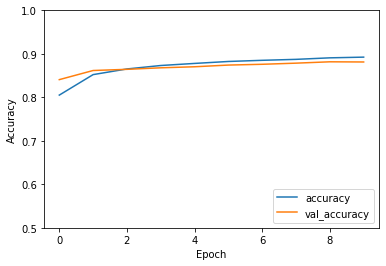

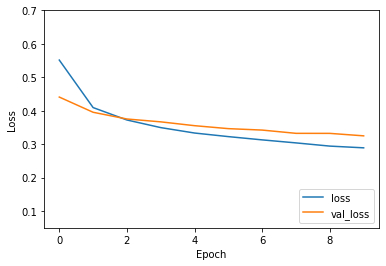

In [27]:
# Plot training performance

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.05, .7])
plt.legend(loc='lower right')
plt.show()

# Predict labels for test images

In [28]:
# Begin by predicting the label for each image in the test set

tf.random.set_seed(0)

predictions = model.predict(test_fs)

In [29]:
#Viewing the first prediction

predictions[0]

array([2.4666824e-06, 5.8839311e-07, 4.7973716e-03, 9.2353169e-08,
       9.8869789e-01, 8.2543844e-10, 6.4998665e-03, 5.5807770e-10,
       1.7862975e-06, 8.4286261e-10], dtype=float32)

In [30]:
# Round the numbers in the prediction array to make it easier to see the position in the array with the highest confidence

np.round(predictions[0],2)

array([0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  ],
      dtype=float32)

In [31]:
# directly derive the confidence in the prediction 

c = 100 * np.max(predictions[0])
c

98.869788646698

In [32]:
# Display the confidence

"{:.2%}".format(np.max(predictions[0]))

'98.87%'

In [33]:
# Display the prediction for the first image in the test set

np.argmax(predictions[0])

4

In [34]:
# Use the class_labels array created earlier to see the actual fashion article

class_labels[np.argmax(predictions[0])]

'Coat'

In [35]:
# Display the first actual test image

for image , label in test_fs.take(1):
  label

In [36]:
class_labels[label[0].numpy()]

'Coat'

# Build a prediction plot

In [37]:
# Taking 30 samples from the test set to see how the model performed 

num = 30
images, labels = [], []
for example in test.take(num):
  image, label = example['image'], example['label']
  images.append(tf.squeeze(image.numpy()))
  labels.append(tf.squeeze(label.numpy()))

In [38]:
def display_test(feature, target, num_images,
                 n_rows, n_cols, cl, p):
  for i in range(num_images):
    plt.subplot(n_rows, 2*n_cols, 2*i+1)
    if cl[target[i]] != cl[np.argmax(p[i])]:
      plt.imshow(feature[i], cmap='Reds')
    else:
      plt.imshow(feature[i], cmap='Blues')
    val = 100*np.max(p[i])
    rounded = str(np.round(val, 2)) + '%'
    plt.title(cl[target[i]] + ' (' +\
              cl[np.argmax(p[i])] + ') ' +\
              rounded )
  plt.tight_layout()
plt.show()

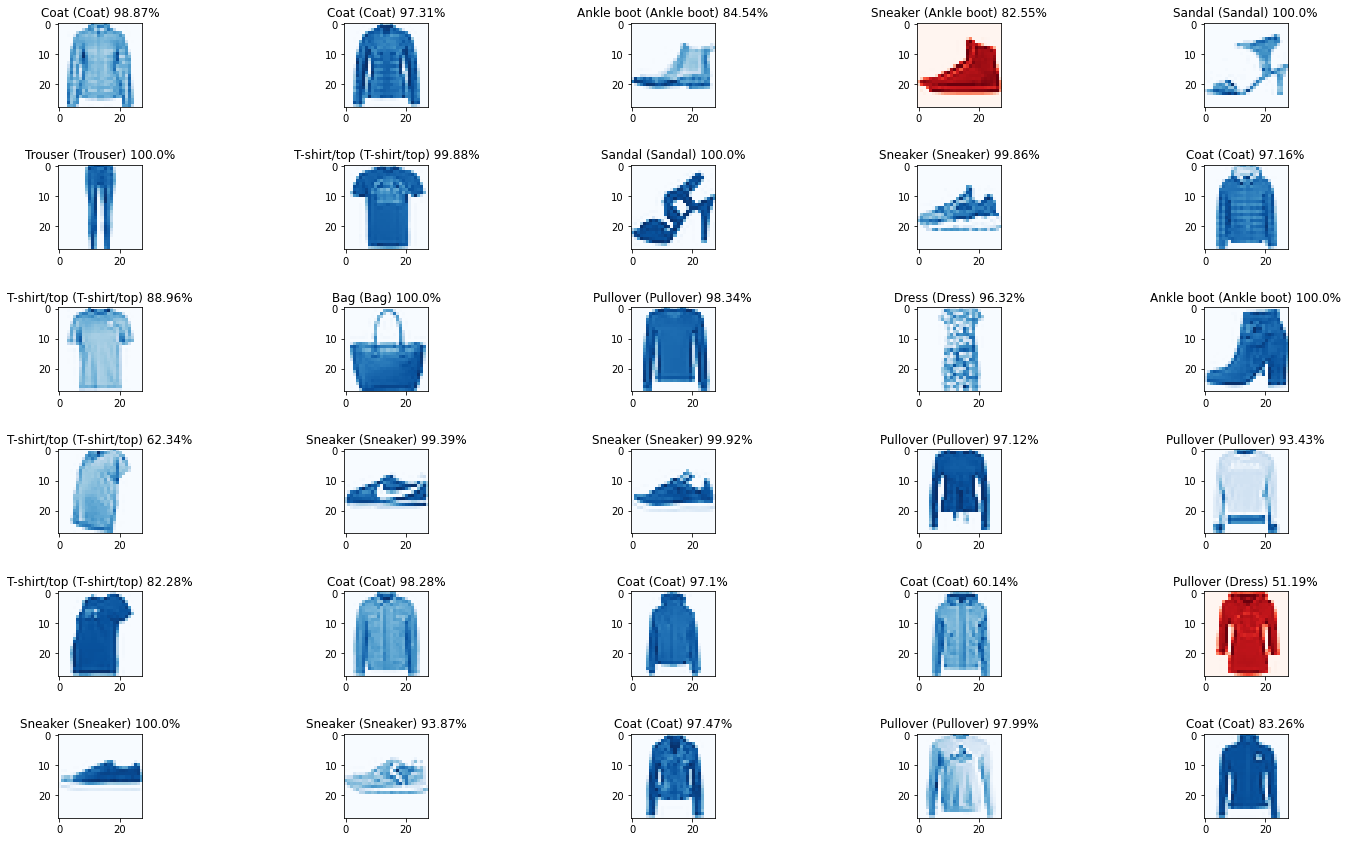

In [39]:
num_rows, num_cols = 6, 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
display_test(images, labels, num_images, num_rows,
             num_cols, class_labels, predictions)

# Load fashion-Mnist as a Keras Dataset

In [40]:
# Loading the keras dataset

train, test = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


# Explore the data

In [41]:
# Displaying the data shapes

print("train data:",br)
print(train[0].shape)
print(train[1].shape,br)
print("test data:",br)
print(test[0].shape)
print(test[1].shape)

train data: 

(60000, 28, 28)
(60000,) 

test data: 

(10000, 28, 28)
(10000,)


In [42]:
#Viewing what the first image represents

class_labels[train[1][0]]

'Ankle boot'

# Visualize the first Image

(-0.5, 27.5, 27.5, -0.5)

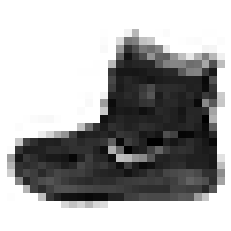

In [43]:
# Plot the first image with matplotlib imshow

plt.imshow(train[0][0], cmap="binary")
plt.axis("off")

In [44]:
# Assign images and labels to variables for convenience

train_images = train[0]
train_labels = train[1]

(-0.5, 27.5, 27.5, -0.5)

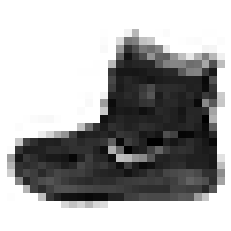

In [45]:
# Plot the first image based on the train_images variable

plt.imshow(train_images[0],cmap="binary")
plt.axis("off")

In [46]:
# access the label name of the first image

class_labels[train_labels[0]]

'Ankle boot'

In [47]:
# Labels are the class IDs ranging from 0 to 9

train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

# Visualize Sample Images

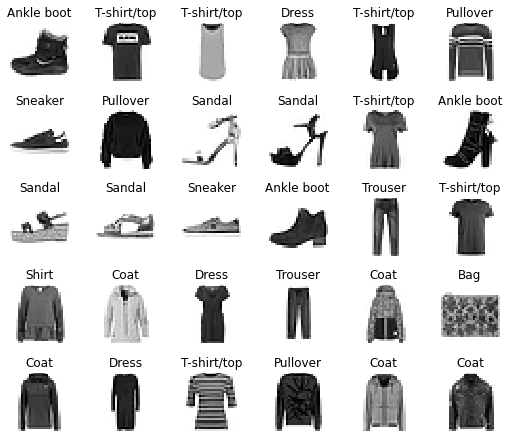

In [48]:
n_rows = 5
n_cols = 6
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
  for col in range(n_cols):
    index = n_cols * row + col
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(train_images[index], cmap='binary',
               interpolation='nearest')
    plt.axis('off')
    plt.title(class_labels[train_labels[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Prepare Data for Training

In [49]:
# add test images and labels to the mix

test_images, test_labels = test

train_pictures = train_images / 255. # to scale
train_targets = train_labels.astype(np.int32)

In [50]:
test_pictures = test_images / 255. # to scale

test_targets = test_labels.astype(np.int32)

In [51]:
print("train images:", len(train_pictures))
print("train labels:",len(train_targets),br)
print("test images", len(test_pictures))
print("test labels", len(test_targets))

train images: 60000
train labels: 60000 

test images 10000
test labels 10000


In [52]:
train_ds = tf.data.Dataset.from_tensor_slices((train_pictures,train_targets))
test_ds = tf.data.Dataset.from_tensor_slices((test_pictures,test_targets))

In [53]:
# Display the tensors

train_ds.element_spec, test_ds.element_spec

((TensorSpec(shape=(28, 28), dtype=tf.float64, name=None),
  TensorSpec(shape=(), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(28, 28), dtype=tf.float64, name=None),
  TensorSpec(shape=(), dtype=tf.int32, name=None)))

In [54]:
# Finishing the input pipeline by shuffling, batching and prefetching train data batching and prefetching test data

BATCH_SIZE = 128

SHUFFLE_BUFFER_SIZE = 5000

train_ks = train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(1)
test_ks = test_ds.batch(BATCH_SIZE).prefetch(1)

In [55]:
# Display the finalized input pipeline tensors

train_ks.element_spec, test_ks.element_spec

((TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)),
 (TensorSpec(shape=(None, 28, 28), dtype=tf.float64, name=None),
  TensorSpec(shape=(None,), dtype=tf.int32, name=None)))

# Build the Model

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

In [57]:
# clear previous model and generate a seed

tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

In [58]:
model = Sequential([Flatten(input_shape=[28,28]),Dense(512,activation="relu"),Dropout(0.4),Dense(10,activation="softmax")])

# Model Summary

In [59]:
# Inspect the model

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


# Compile the Model

In [60]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

# Train the Model

In [61]:
history = model.fit(train_ks,epochs=10,validation_data=test_ks)

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.5486 - accuracy: 0.8069 - val_loss: 0.4296 - val_accuracy: 0.8500
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.4098 - accuracy: 0.8535 - val_loss: 0.4030 - val_accuracy: 0.8550
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3751 - accuracy: 0.8646 - val_loss: 0.3771 - val_accuracy: 0.8616
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3494 - accuracy: 0.8738 - val_loss: 0.3611 - val_accuracy: 0.8694
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3347 - accuracy: 0.8769 - val_loss: 0.3494 - val_accuracy: 0.8733
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3243 - accuracy: 0.8814 - val_loss: 0.3423 - val_accuracy: 0.8761
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.3112 - accuracy: 0.8843 - val_loss: 0.3581 - val_accuracy: 0.8716
Epoch 

# Generalize on test Data

In [62]:
print("Test accuracy:",end="  ")
test_loss , test_acc = model.evaluate(test_ks,verbose=2)

Test accuracy:  79/79 - 0s - loss: 0.3221 - accuracy: 0.8835


# Visualize Training

In [63]:
# Display the dictionary keys to inform us on how to plot results


hist_dict = history.history
print(hist_dict, "\n")
print(hist_dict.keys())

{'loss': [0.5485945343971252, 0.4097749590873718, 0.37514495849609375, 0.34941333532333374, 0.33467406034469604, 0.32427382469177246, 0.3111882507801056, 0.3049972951412201, 0.2988671660423279, 0.2901664972305298], 'accuracy': [0.8069166541099548, 0.8535333275794983, 0.8646000027656555, 0.8738166689872742, 0.876883327960968, 0.8813666701316833, 0.8843166828155518, 0.8856666684150696, 0.8904500007629395, 0.89205002784729], 'val_loss': [0.429585337638855, 0.40299731492996216, 0.3770599365234375, 0.36114466190338135, 0.3493889272212982, 0.3423016369342804, 0.3580683171749115, 0.33397364616394043, 0.3576909303665161, 0.3221449851989746], 'val_accuracy': [0.8500000238418579, 0.8550000190734863, 0.8615999817848206, 0.8694000244140625, 0.8733000159263611, 0.8761000037193298, 0.8715999722480774, 0.8805000185966492, 0.868399977684021, 0.8834999799728394]} 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [64]:
history.params

{'epochs': 10, 'steps': 469, 'verbose': 1}

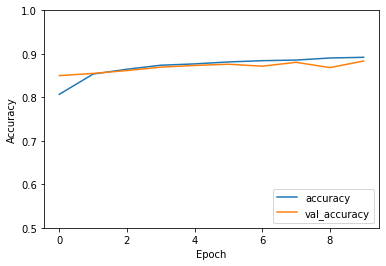

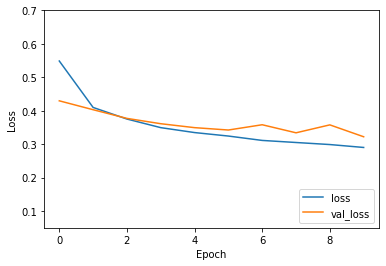

In [65]:
# plotting training history

plt.plot(history.history["accuracy"],label="accuracy")
plt.plot(history.history["val_accuracy"],label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5,1])
plt.legend(loc="lower right")
plt.show()

plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0.05,.7])
plt.legend(loc="lower right")
plt.show()

# Predict Labels for Test Images

In [66]:
# Predict the label for each image from the test set test_ks

predictions = model.predict(test_ks)

# Predict the first image

In [67]:
# Viewing the first prediction

predictions[0]

array([4.7537496e-06, 5.1410063e-07, 1.3129711e-06, 1.3874860e-07,
       3.7810753e-07, 4.7208313e-02, 3.3125175e-06, 8.0327176e-02,
       5.5853074e-05, 8.7239826e-01], dtype=float32)

In [68]:
# Rounding the array for convenience

np.round(predictions[0],2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.08, 0.  , 0.87],
      dtype=float32)

In [69]:
# Directly access the confidence in the prediction

100*np.max(predictions[0])

87.23982572555542

In [70]:
#Display the prediction for the first image

np.argmax(predictions[0])

9

In [71]:
# Using class labels to see the actual prediction

class_labels[np.argmax(predictions[0])]

'Ankle boot'

In [72]:
#Display the actual test label for comparison

class_labels[test_labels[0]]

'Ankle boot'

# Predict four images

In [73]:
#make four predictions from the test set

pred_4 = predictions[:4]

In [74]:
# Show the predictions

ls = [np.argmax(row) for row in pred_4]
ls

[9, 2, 1, 1]

In [75]:
# Get class labels

np.array(class_labels)[ls]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser'], dtype='<U11')

In [76]:
# Compare predictions to the test dataset

actual_4 = test_labels[:4]
actual_4

array([9, 2, 1, 1], dtype=uint8)

In [77]:
# Showing actuals as class labels

np.array(class_labels)[actual_4]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser'], dtype='<U11')

In [78]:
#Visualize the predictions

#slice off the first 4 images from the test data

img_4 = test_images[:4]

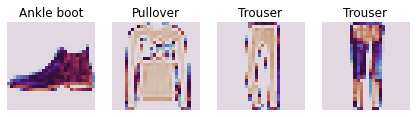

In [79]:
# plot images

plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(img_4):
  plt.subplot(1, 4, index + 1)
  plt.imshow(image, cmap='twilight', interpolation='nearest')
  plt.axis('off')
  plt.title(class_labels[actual_4[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Explore Misclassifications

In [80]:
# Trying to find misclassifications

#first step is to id prediction labels

rng = len(predictions)

y_pred = [np.argmax(row) for row in predictions]

In [81]:
# Getting some predictions and actual targets


# finding the first n predictions and actual targets

n = 20

y_n = [y_pred[i] for i, row in enumerate(range(n)) ]
y_actual = [test_labels[i] for i, row in enumerate(range(n))]

y_n , y_actual

([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 2, 8, 0],
 [9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0])

In [82]:
# Finding misclassifications

# Compare predictions against actual targets

miss_indx_list = [index for index, (x,y) in enumerate(zip(y_n,y_actual)) if x != y]

miss_indx_list

[12, 17]

In [83]:
# display confidence for each misclassfication:

for row in miss_indx_list:
  val = 100*np.max(predictions[row])
  rounded = str(round(val, 2)) + '%'
  print ('index:', row, 'confidence:', rounded,
         'pred:', class_labels[np.argmax(predictions[row])],
         'actual:', class_labels[test_labels[row]])

index: 12 confidence: 94.37% pred: Sandal actual: Sneaker
index: 17 confidence: 69.91% pred: Pullover actual: Coat


# Visualize Misclassifications

In [84]:
def see_misses(indx):
  plt.imshow(test_images[indx], cmap='nipy_spectral')
  plt.show()
  print ('actual:', class_labels[test_labels[indx]])
  print ('predicted:',
         class_labels[np.argmax(predictions[indx])])
  print ('confidence', rounded)

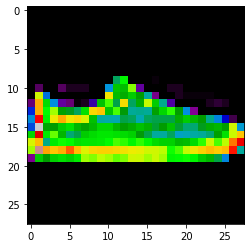

actual: Sneaker
predicted: Sandal
confidence 94.37%


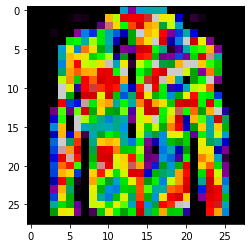

actual: Coat
predicted: Pullover
confidence 69.91%


In [85]:
# Invoke the function

for row in miss_indx_list:
  val = 100*np.max(predictions[row])
  rounded = str(round(val, 2)) + '%'
  see_misses(row)

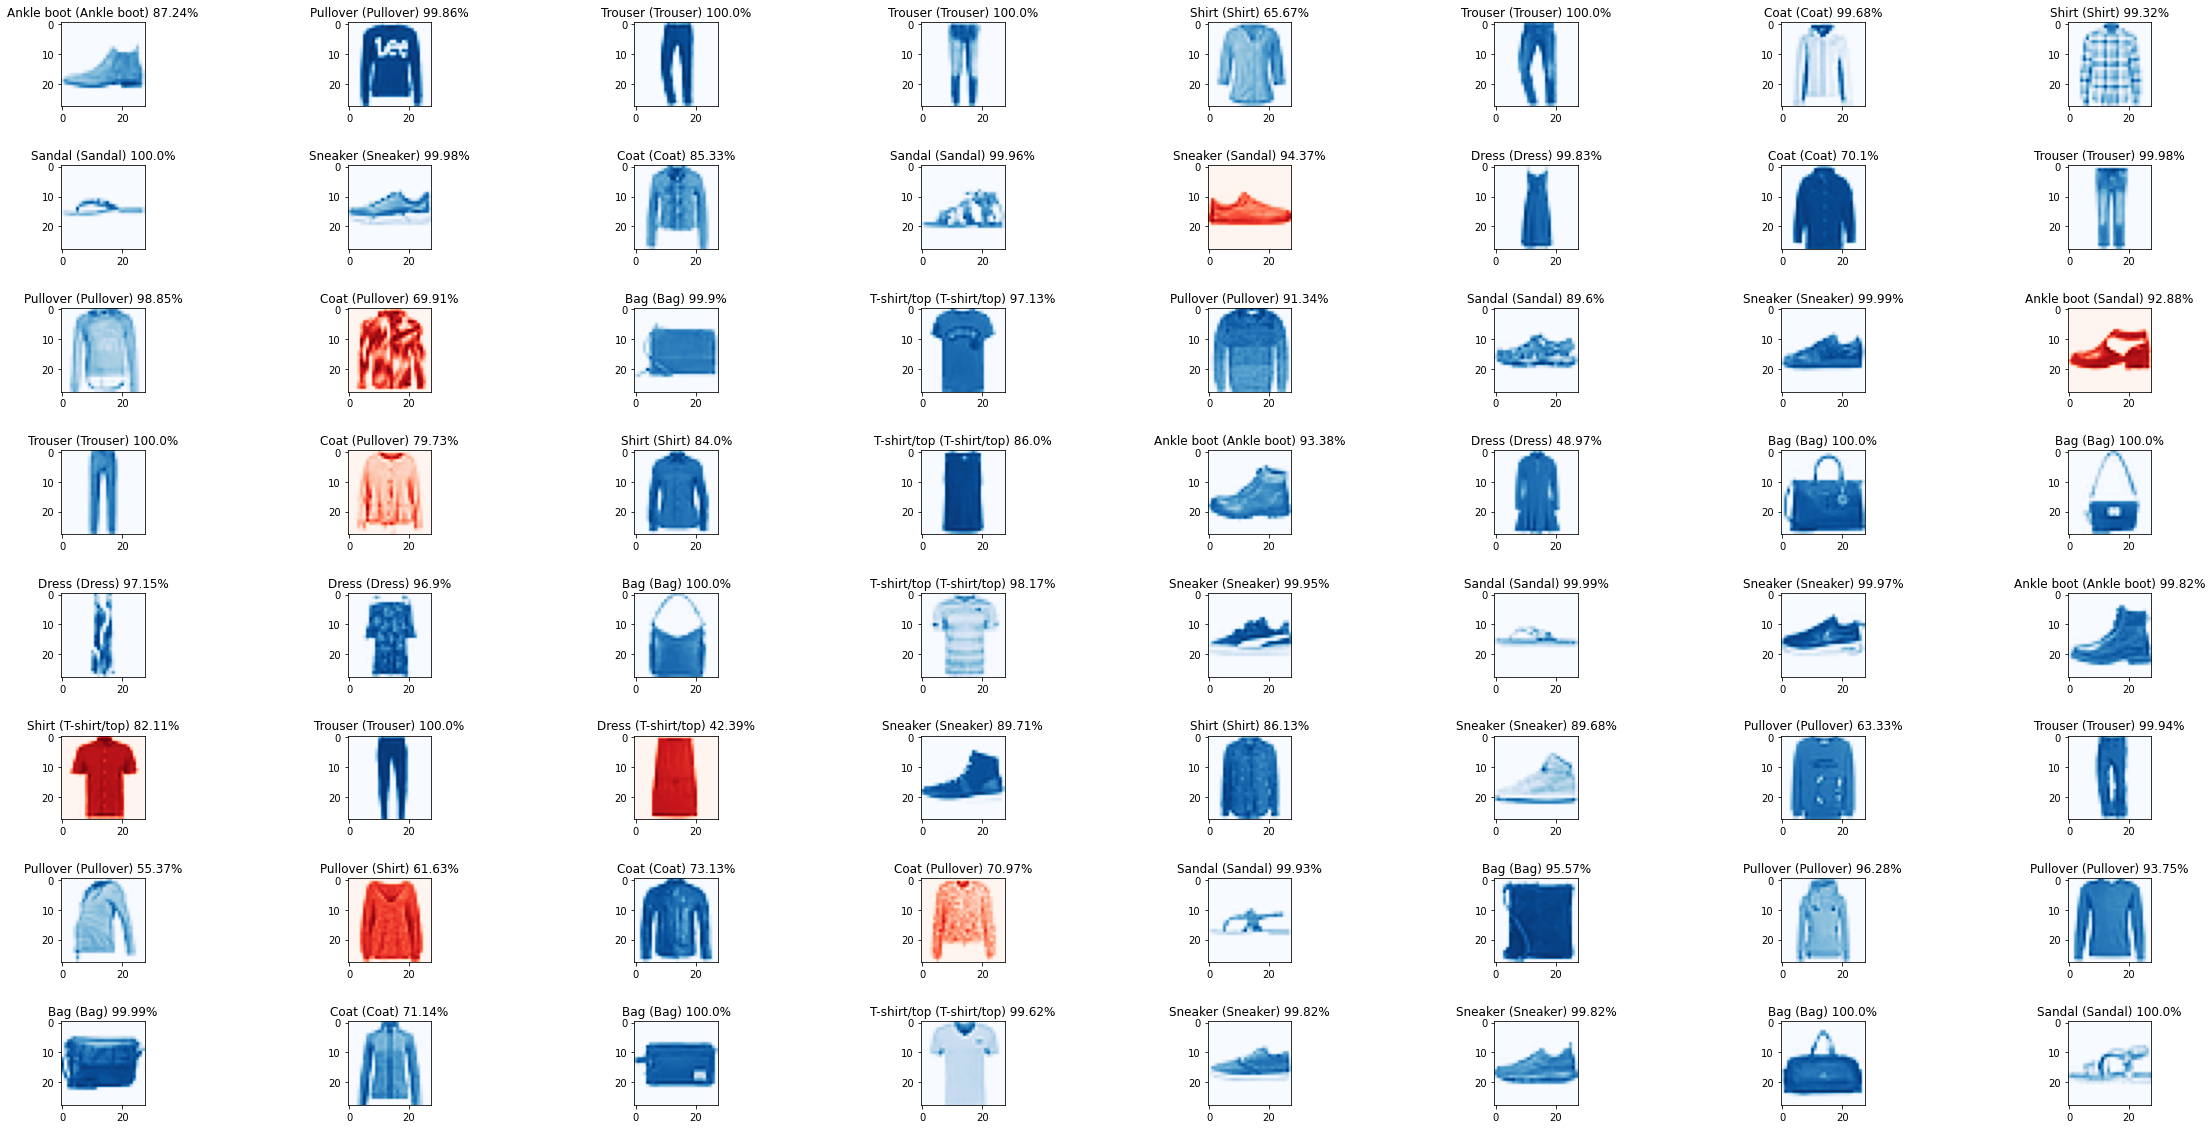

In [86]:
# Plot the first X test images, their true labels,
# their predicted labels, and prediction confidence.

num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  if class_labels[test_labels[i]] != class_labels[y_pred[i]]:
    plt.imshow(test_images[i], cmap='Reds')
  else:
    plt.imshow(test_images[i], cmap='Blues')
  val = 100*np.max(predictions[i])
  rounded = str(np.round(val, 2)) + '%'
  plt.title(class_labels[test_labels[i]] + ' (' +\
            class_labels[y_pred[i]] + ') ' + rounded )
plt.tight_layout()
plt.show()

# Predict from a single image

In [87]:
# Randomly choose an image from the test set


beg , end = 0 , len(test_images) - 1
rng = np.random.default_rng()
indx = int(rng.uniform(beg,end,size=1))
indx

5464

In [88]:
# Grab the image from the test set

img = test_images[indx]
label = class_labels[test_labels[indx]]
img.shape , label

((28, 28), 'Coat')

In [89]:
# Create a batch with a single image

img_batch = np.expand_dims(img,0)
img.shape

(28, 28)

In [90]:
# predicting

pred_single = model.predict(img_batch)

In [91]:
#Display prediction

np.argmax(pred_single)

4

In [92]:
# Displaying the prediction by label name:

class_labels[np.argmax(pred_single)]

'Coat'

In [93]:
#Displaying the actual label

class_labels[test_labels[indx]]

'Coat'

# Visualize Single Image Prediction

In [94]:
# Visualize the prediction

pred = class_labels[np.argmax(pred_single)]
actual = class_labels[test_labels[indx]]

In [95]:
# get confidence from the predictions object


val = 100 * np.max(predictions[indx])
rounded = str(np.round(val,2)) + "%"

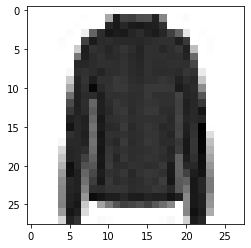

actual:  Coat
predicted:  Coat
confidence:  50.84%


In [96]:
# display actual image

plt.imshow(test_images[indx], cmap=plt.cm.binary)
plt.show()

print("actual: ", actual)
print("predicted: ",pred)
print("confidence: ", rounded)

# Confusion Matrix

In [97]:
# Creating a confusion matrix to visually demonstrate how well the model classified articles of clothing from fashion-MNIST

tf.math.confusion_matrix(test_labels,y_pred)

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[897,   0,  18,  20,   5,   1,  56,   0,   3,   0],
       [  2, 971,   0,  21,   3,   0,   2,   0,   1,   0],
       [ 23,   0, 831,  13,  87,   0,  45,   0,   1,   0],
       [ 33,   7,  14, 910,  18,   0,  16,   0,   2,   0],
       [  0,   0, 115,  58, 774,   0,  51,   0,   2,   0],
       [  0,   0,   0,   0,   0, 963,   0,  23,   0,  14],
       [190,   0,  98,  29,  73,   1, 598,   0,  11,   0],
       [  0,   0,   0,   0,   0,  11,   0, 972,   0,  17],
       [  5,   0,   6,   5,   4,   2,   2,   2, 974,   0],
       [  0,   0,   0,   0,   0,   7,   1,  47,   0, 945]], dtype=int32)>